## Import thư viện

In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import re
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
import tensorflow
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,Dropout,Flatten
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import warnings
warnings.filterwarnings('ignore')
import time
from wordcloud import WordCloud

E:\Orancale\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Data Exploration

In [2]:
data = pd.read_csv('SMSSpamCollection.txt', sep='\t', header=None, names=['Target', 'Text'])
data.head()

,Target,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
print(f'Số dòng của bộ dữ liệu là:{data.shape[0]} dòng')
print(f'Số cột của bộ dữ liệu là:{data.shape[1]} cột')

Số dòng của bộ dữ liệu là:5572 dòng
Số cột của bộ dữ liệu là:2 cột


In [4]:
data.columns

Index(['Target', 'Text'], dtype='object')

In [5]:
# Kiểm tra xem có phải cột Target chỉ có 2 giá trị là ham và spam hay không
unique_values = data['Target'].unique()
print(unique_values)

['ham' 'spam']


## Data preprocessing

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Target  5572 non-null   object
 1   Text    5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [7]:
# Kiểm tra nếu có bất kỳ giá trị nào thiếu trong toàn bộ DataFrame
missing_any = data.isnull().any().sum()

# Kiểm tra nếu có bất kỳ dòng nào trùng lặp trong toàn bộ DataFrame
duplicate_any = data.duplicated().any()

print("Có giá trị thiếu:", missing_any)
print("Có dòng trùng lặp:", duplicate_any)

Có giá trị thiếu: 0
Có dòng trùng lặp: True


In [8]:
# Kiểm tra dòng trùng lặp
duplicate_mask = data.duplicated()
# Lọc và in ra các dòng trùng lặp
duplicate_rows = data[duplicate_mask]
print("Các dòng trùng lặp:")
duplicate_rows

Các dòng trùng lặp:


,Target,Text
103,ham,As per your request 'Melle Melle (Oru Minnamin...
154,ham,As per your request 'Melle Melle (Oru Minnamin...
207,ham,"As I entered my cabin my PA said, '' Happy B'd..."
223,ham,"Sorry, I'll call later"
326,ham,No calls..messages..missed calls
...,...,...
5524,spam,You are awarded a SiPix Digital Camera! call 0...
5535,ham,"I know you are thinkin malaria. But relax, chi..."
5539,ham,Just sleeping..and surfing
5553,ham,Hahaha..use your brain dear


In [9]:
duplicate_rows['count'] = duplicate_rows.groupby('Text')['Text'].transform('count')
duplicate_rows[duplicate_rows['count'] == 1]

,Target,Text,count
357,spam,Congratulations ur awarded 500 of CD vouchers ...,1
533,ham,Gudnite....tc...practice going on,1
825,ham,Have a good evening! Ttyl,1
850,spam,Today's Offer! Claim ur £150 worth of discount...,1
900,spam,Your free ringtone is waiting to be collected....,1
...,...,...,...
5471,ham,Yup,1
5497,spam,"SMS SERVICES. for your inclusive text credits,...",1
5510,ham,I went to project centre,1
5524,spam,You are awarded a SiPix Digital Camera! call 0...,1


## Text Mining

In [10]:
start_time_Lemma = time.time()

def expand_abbreviations(text):
    abbreviation_dict = {
        " u ": " you ",
        "dun": "do not",
        "don": "do not",
        "cant": "can not",
        "pl": "please",
        "dont": "do not"
    }
    for abbr, expanded in abbreviation_dict.items():
        text = text.replace(abbr, expanded)
    return text

def remove_non_alphabetic(text):
    return re.sub('[^A-Za-z]', ' ', text)

def convert_to_lowercase(text):
    return text.lower()

def tokenize_lemmatize_remove_stopwords(text, lemma):
    words = word_tokenize(text)
    words = [lemma.lemmatize(word) for word in words if word not in stopwords.words('english')]
    return ' '.join(words)

def preprocess(sentences):
    lemma = WordNetLemmatizer()
    processed_sentences = []

    for text in sentences:
        # Expand abbreviations
        text = expand_abbreviations(text)

        # Remove non-alphabetic characters
        text = remove_non_alphabetic(text)

        # Convert to lowercase
        text = convert_to_lowercase(text)

        # Tokenize, lemmatize, and remove stopwords
        processed_sentence = tokenize_lemmatize_remove_stopwords(text, lemma)
        
        processed_sentences.append(processed_sentence)

    return processed_sentences
data['Lemma_Text_Process'] = preprocess(data['Text'])
end_time_Lemma = time.time()
Lemma_time = end_time_Lemma - start_time_Lemma

In [11]:
data.head()

,Target,Text,Lemma_Text_Process
0,ham,"Go until jurong point, crazy.. Available only ...",go jurong point crazy available bugis n great ...
1,ham,Ok lar... Joking wif u oni...,ok lar joking wif oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry wkly comp win fa cup final tkts st ...
3,ham,U dun say so early hor... U c already then say...,u say early hor u c already say
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah think go usf life around though


In [12]:
start_time_Count = time.time()

cv = CountVectorizer(max_features=5000)
features = cv.fit_transform(data['Lemma_Text_Process']).toarray()

end_time_Count = time.time()
Count_time = end_time_Count - start_time_Count

print(f"Thời gian xử lý vector hóa bằng CountVectorizer: {Count_time:.5f} giây")

Thời gian xử lý vector hóa bằng CountVectorizer: 0.06733 giây


In [13]:
total_time = Lemma_time + Count_time
print(f'Thời gian xử lý văn bản bằng Lemma_CountVectorizer: {total_time:.5f} giây')

Thời gian xử lý văn bản bằng Lemma_CountVectorization: 11.71651 giây


## EDA

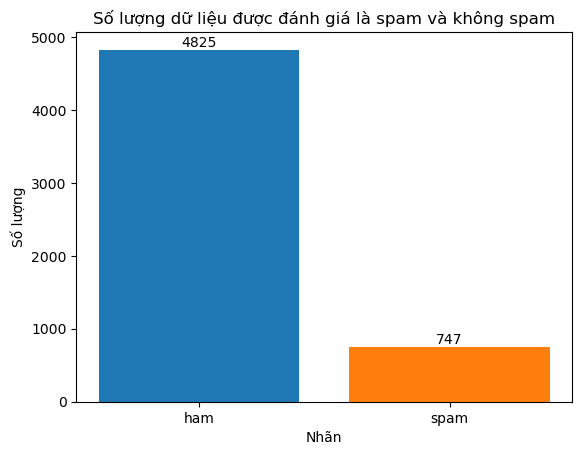

In [14]:
target_counts = data['Target'].value_counts()
bar_colors = ['#ff7f0e' if label=='spam' else '#1f77b4' for label in target_counts.index]
bars = plt.bar(target_counts.index, target_counts.values, color=bar_colors)

# Thêm con số lên trên đầu các cột
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 1), ha='center', va='bottom', color='black')

# Đặt nhãn và tiêu đề
plt.xlabel('Nhãn')
plt.ylabel('Số lượng')
plt.title('Số lượng dữ liệu được đánh giá là spam và không spam')

# Hiển thị biểu đồ
plt.show()

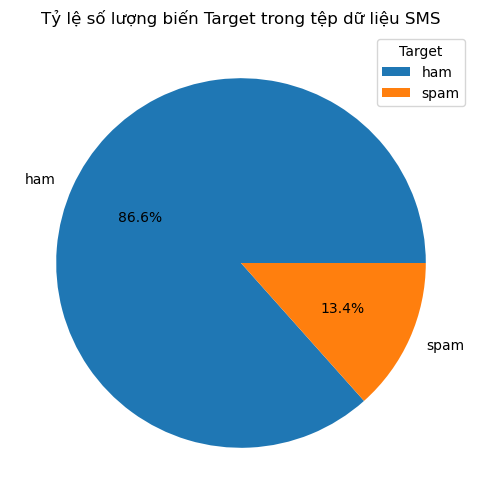

In [15]:
target_counts = data['Target'].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(target_counts, labels=target_counts.index, autopct='%1.1f%%')
plt.title('Tỷ lệ số lượng biến Target trong tệp dữ liệu SMS')
plt.legend(title="Target", labels=target_counts.index)
plt.show()

### Full Target

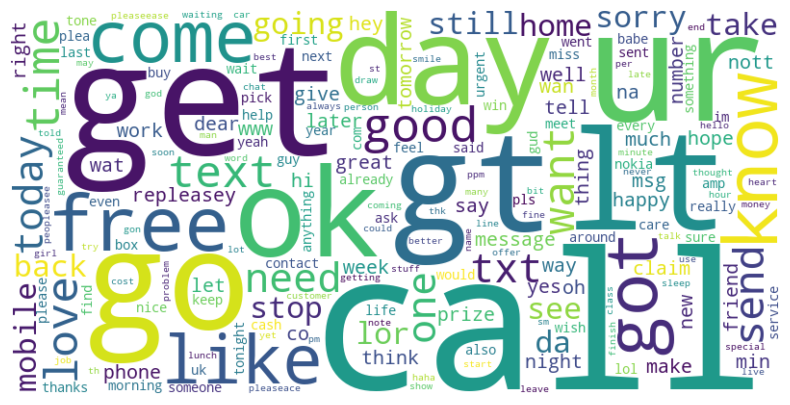

In [16]:
word_freq_full = np.sum(features, axis=0)
words_full = cv.get_feature_names_out()
word_freq_dict_full = dict(zip(words_full, word_freq_full))

wordcloud_full = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq_dict_full)

# Display the word cloud image
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_full, interpolation='bilinear')
plt.axis('off')  # Remove the axis
plt.show()

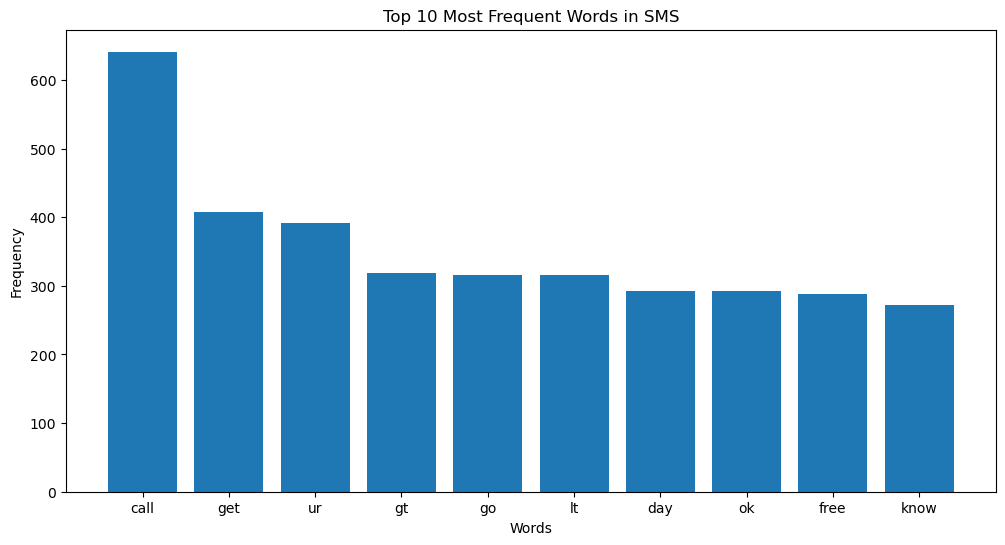

In [17]:
sorted_words_full = sorted(word_freq_dict_full.items(), key=lambda x: x[1], reverse=True)[:10] # top 10 words
words_full, frequencies_full = zip(*sorted_words_full)

plt.figure(figsize=(12, 6))
plt.bar(words_full, frequencies_full)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 10 Most Frequent Words in SMS')
plt.show()

### Spam Target

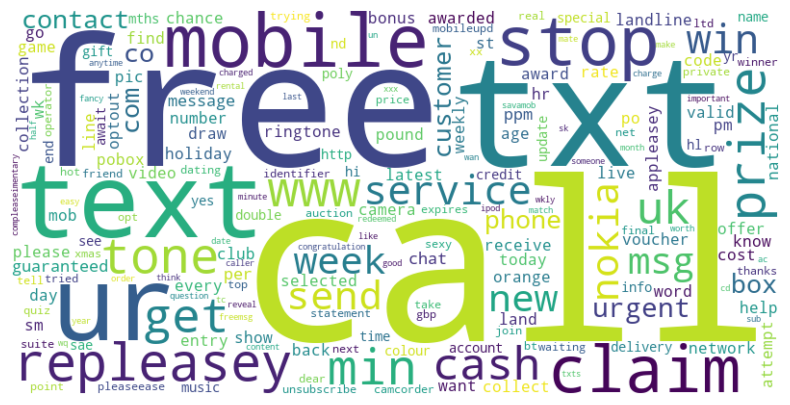

In [18]:
spam_data = data[data['Target'] == 'spam']
features_spam=cv.fit_transform(spam_data['LemmaStemmer_Text_Process'])
features_spam=features_spam.toarray()

word_freq_spam = np.sum(features_spam, axis=0)
words_spam = cv.get_feature_names_out()
word_freq_dict_spam = dict(zip(words_spam, word_freq_spam))

wordcloud_spam = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq_dict_spam)

# Display the word cloud image
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_spam, interpolation='bilinear')
plt.axis('off')  # Remove the axis
plt.show()

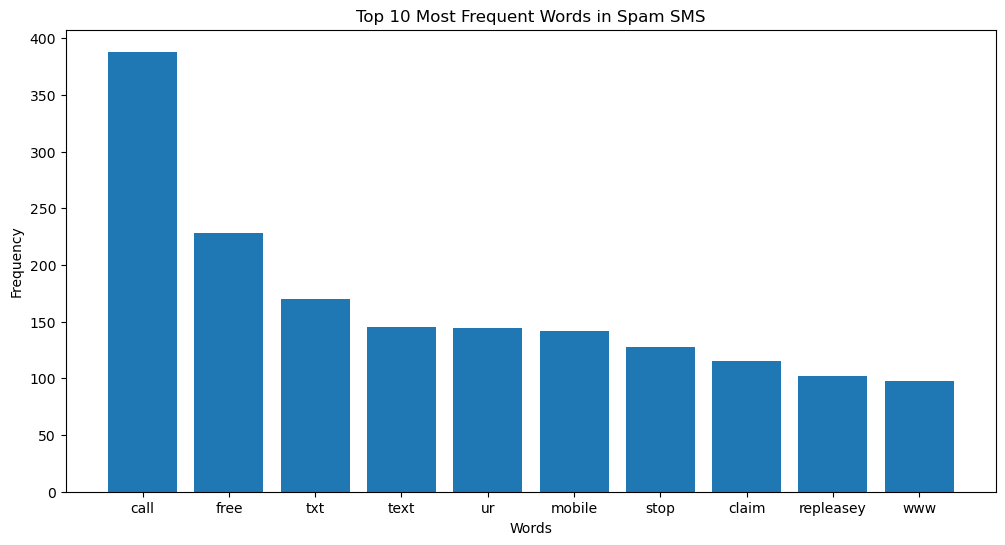

In [19]:
sorted_words_spam = sorted(word_freq_dict_spam.items(), key=lambda x: x[1], reverse=True)[:10] # top 10 words
words_spam, frequencies_spam = zip(*sorted_words_spam)

plt.figure(figsize=(12, 6))
plt.bar(words_spam, frequencies_spam)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 10 Most Frequent Words in Spam SMS')
plt.show()

### Ham Target

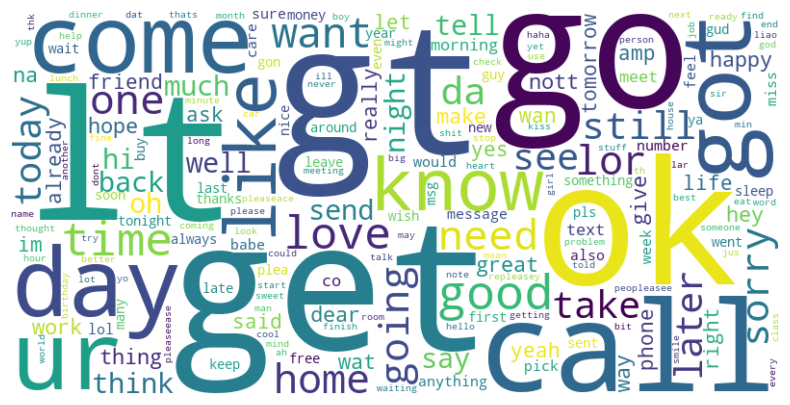

In [20]:
ham_data = data[data['Target'] == 'ham']
features_ham=cv.fit_transform(ham_data['LemmaStemmer_Text_Process'])
features_ham=features_ham.toarray()

word_freq_ham = np.sum(features_ham, axis=0)
words_ham = cv.get_feature_names_out()
word_freq_dict_ham = dict(zip(words_ham, word_freq_ham))

wordcloud_ham = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq_dict_ham)

# Display the word cloud image
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_ham, interpolation='bilinear')
plt.axis('off')  # Remove the axis
plt.show()

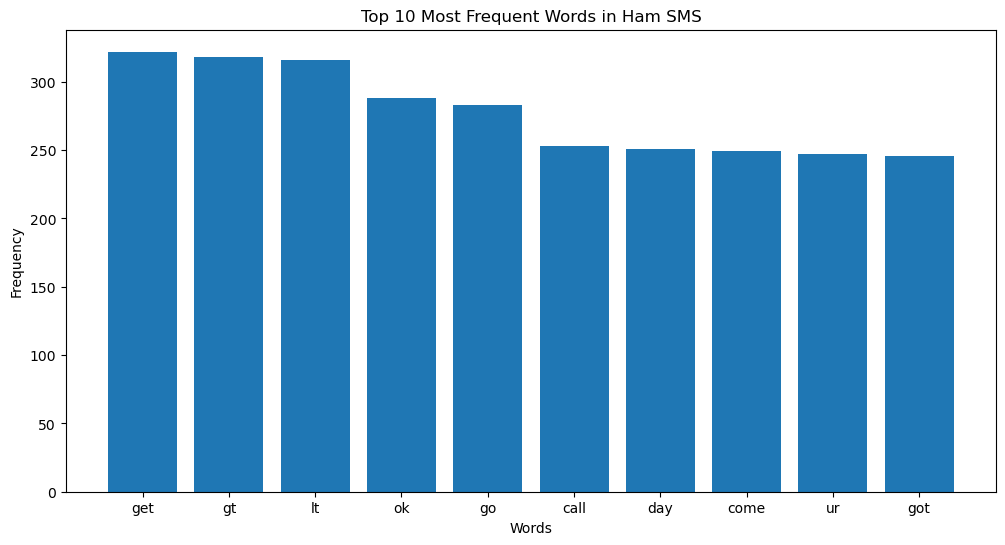

In [21]:
sorted_words_ham = sorted(word_freq_dict_ham.items(), key=lambda x: x[1], reverse=True)[:10] 
words_ham, frequencies_ham = zip(*sorted_words_ham)

plt.figure(figsize=(12, 6))
plt.bar(words_ham, frequencies_ham)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 10 Most Frequent Words in Ham SMS')
plt.show()

## Prepare the Data

In [22]:
X = features
y = data['Target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle = True)

In [23]:
X_train_shape = X_train.shape
X_test_shape = X_test.shape
y_train_shape = (len(y_train),)
y_test_shape = (len(y_test),)

X_train_shape, X_test_shape, y_train_shape, y_test_shape

((4457, 5000), (1115, 5000), (4457,), (1115,))

## Machine Learning

### MultinomialNB

In [24]:
nb_model=MultinomialNB()
nb_model.get_params()

{'alpha': 1.0, 'class_prior': None, 'fit_prior': True, 'force_alpha': 'warn'}

In [25]:
start_time = time.time()

nb_model.fit(X_train,y_train)

y_pred = nb_model.predict(X_test)
end_time = time.time()

execution_time = end_time - start_time
accuracy = accuracy_score(y_test, y_pred)

print('--------------------------------------MultinomialNB---------------------------------------------------')
print(classification_report(y_test, y_pred))
print(f'Accuracy: {accuracy*100:.2f}%')
print(f"Thời gian MultinomialNB Model: {execution_time:.5f} giây")

--------------------------------------MultinomialNB---------------------------------------------------
              precision    recall  f1-score   support

         ham       0.99      0.98      0.99       966
        spam       0.90      0.95      0.93       149

    accuracy                           0.98      1115
   macro avg       0.95      0.97      0.96      1115
weighted avg       0.98      0.98      0.98      1115

Accuracy: 98.03%
Thời gian MultinomialNB Model: 0.36625 giây


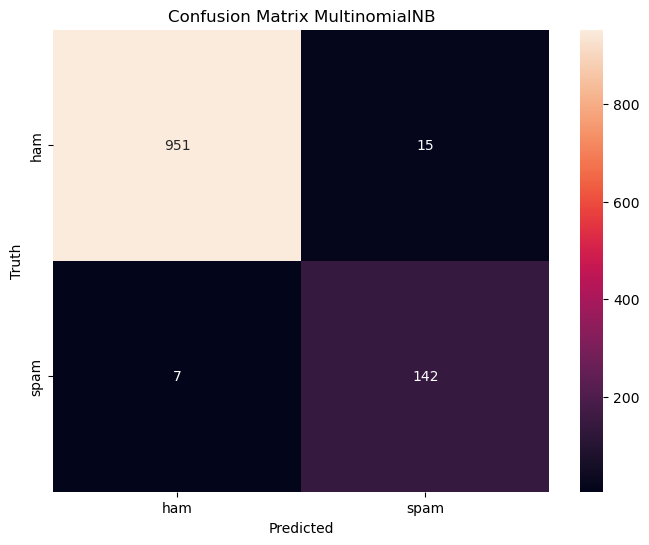

In [26]:
cm_nb = confusion_matrix(y_test, y_pred)
labels = y_test.unique()

plt.figure(figsize=(8,6))
sns.heatmap(cm_nb, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title('Confusion Matrix MultinomialNB')
plt.show()

### SVM

In [27]:
svm_model = SVC(kernel='linear')
svm_model.get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'linear',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [28]:
start_time = time.time()

svm_model.fit(X_train, y_train)

y_pred = svm_model.predict(X_test)
end_time = time.time()

execution_time = end_time - start_time
accuracy = accuracy_score(y_test, y_pred)

print('-----------------------------------------Suport Vector Machine------------------------------------------------')
print(classification_report(y_test, y_pred))
print(f'Accuracy: {accuracy*100:.2f}%')
print(f"Thời gian SVM Model: {execution_time:.5f} giây")

-----------------------------------------Suport Vector Machine------------------------------------------------
              precision    recall  f1-score   support

         ham       0.98      1.00      0.99       966
        spam       0.99      0.89      0.94       149

    accuracy                           0.98      1115
   macro avg       0.99      0.95      0.97      1115
weighted avg       0.98      0.98      0.98      1115

Accuracy: 98.48%
Thời gian SVM Model: 8.96116 giây


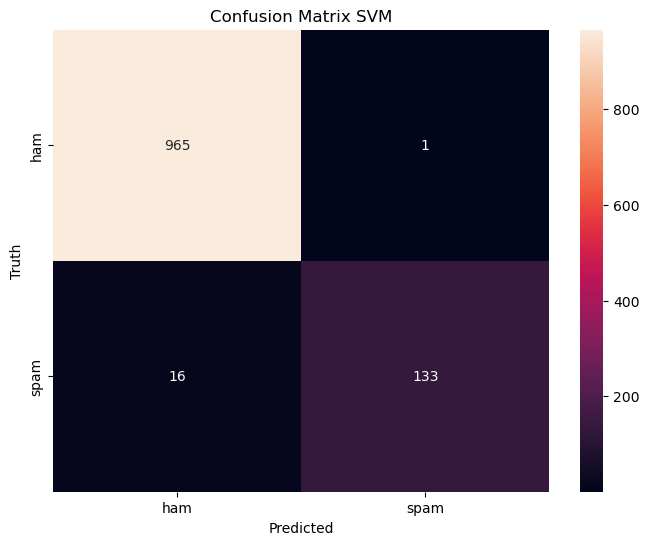

In [29]:
cm_svm = confusion_matrix(y_test, y_pred)
labels = y_test.unique()

plt.figure(figsize=(8,6))
sns.heatmap(cm_svm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title('Confusion Matrix SVM')
plt.show()

### Decision Tree

In [30]:
tree_model = DecisionTreeClassifier()
tree_model.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [31]:
start_time = time.time()

tree_model.fit(X_train, y_train)

y_pred = tree_model.predict(X_test)
end_time = time.time()

accuracy = accuracy_score(y_test, y_pred)
execution_time = end_time - start_time

print('-----------------------------------------Decision Tree------------------------------------------------')
print(classification_report(y_test, y_pred))
print(f'Accuracy: {accuracy*100:.2f}%')
print(f"Thời gian Decision Tree: {execution_time:.5f} giây")

-----------------------------------------Decision Tree------------------------------------------------
              precision    recall  f1-score   support

         ham       0.98      0.99      0.99       966
        spam       0.93      0.88      0.90       149

    accuracy                           0.97      1115
   macro avg       0.96      0.93      0.94      1115
weighted avg       0.97      0.97      0.97      1115

Accuracy: 97.49%
Thời gian Decision Tree: 8.94563 giây


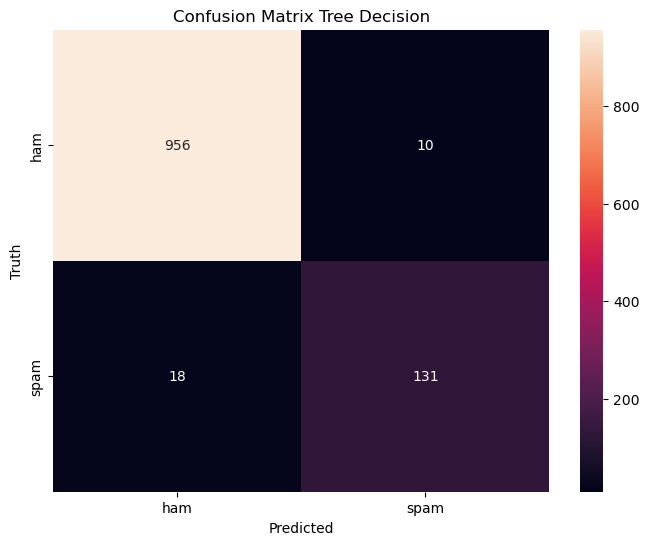

In [32]:
cm_td = confusion_matrix(y_test, y_pred)
labels = y_test.unique()

plt.figure(figsize=(8,6))
sns.heatmap(cm_td, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title('Confusion Matrix Tree Decision')
plt.show()

### LogisticRegression

In [33]:
lr_model = LogisticRegression()
lr_model.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [34]:
start_time = time.time()

lr_model.fit(X_train, y_train)

y_pred = lr_model.predict(X_test)
end_time = time.time()

accuracy = accuracy_score(y_test, y_pred)
execution_time = end_time - start_time

print('-----------------------------------------Logistic Regression------------------------------------------------')
print(classification_report(y_test, y_pred))
print(f'Accuracy: {accuracy*100:.2f}%')
print(f"Thời gian Logistic Regression Model: {execution_time:.5f} giây")

-----------------------------------------Logistic Regression------------------------------------------------
              precision    recall  f1-score   support

         ham       0.98      1.00      0.99       966
        spam       1.00      0.89      0.94       149

    accuracy                           0.98      1115
   macro avg       0.99      0.94      0.97      1115
weighted avg       0.99      0.98      0.98      1115

Accuracy: 98.48%
Thời gian Logistic Regression Model: 0.96488 giây


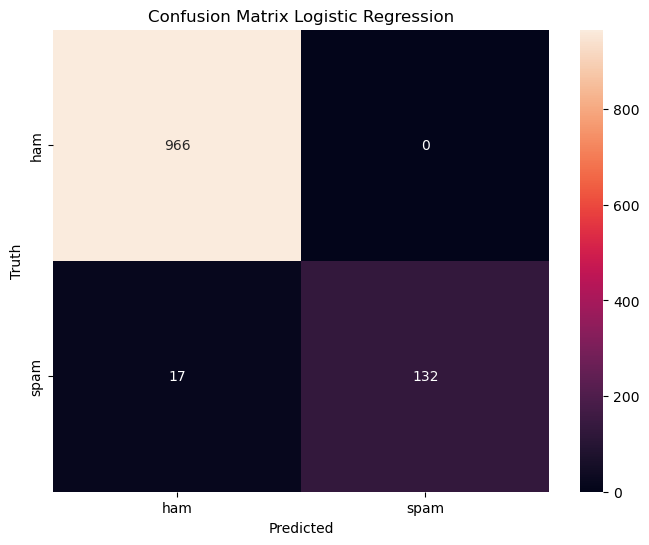

In [35]:
cm_lr = confusion_matrix(y_test, y_pred)
labels = y_test.unique()

plt.figure(figsize=(8,6))
sns.heatmap(cm_lr, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title('Confusion Matrix Logistic Regression')
plt.show()

# Evaluation

In [36]:
from sklearn.model_selection import GridSearchCV

# Định nghĩa các giá trị thử nghiệm cho các siêu tham số
param_grid = {
    'alpha': [0.1, 0.5, 1.0, 1.5, 2.0],  # Thay đổi giá trị của alpha
    'fit_prior': [True, False],  # Thử nghiệm với fit_prior là True và False
    'class_prior': [None, [0.2, 0.8], [0.5, 0.5]]  # Thử nghiệm với các giá trị khác nhau cho class_prior
}

# Tạo một đối tượng GridSearchCV để tìm kiếm siêu tham số tốt nhất
grid_search = GridSearchCV(estimator=MultinomialNB(), param_grid=param_grid, scoring='accuracy', cv=5)
grid_search.fit(X_train, y_train)

# In ra siêu tham số tốt nhất
print("Best Parameters: ", grid_search.best_params_)

# Sử dụng mô hình với siêu tham số tốt nhất để đánh giá trên tập kiểm tra
best_nb_model = grid_search.best_estimator_
y_pred_tuned = best_nb_model.predict(X_test)

# In ra báo cáo phân loại và độ chính xác
print('--------------------------------------Tuned MultinomialNB---------------------------------------------------')
print(classification_report(y_test, y_pred_tuned))
accuracy_tuned = accuracy_score(y_test, y_pred_tuned)
print(f'Accuracy (Tuned): {accuracy_tuned * 100:.2f}%')

Best Parameters:  {'alpha': 2.0, 'class_prior': None, 'fit_prior': True}
--------------------------------------Tuned MultinomialNB---------------------------------------------------
              precision    recall  f1-score   support

         ham       0.99      0.99      0.99       966
        spam       0.92      0.95      0.93       149

    accuracy                           0.98      1115
   macro avg       0.96      0.97      0.96      1115
weighted avg       0.98      0.98      0.98      1115

Accuracy (Tuned): 98.21%


## SVC

In [39]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score

# Define the parameter grid for SVM with a linear kernel
param_grid_svm_linear = {
    'C': [0.1, 1, 10],              # Thay đổi giá trị của hằng số ứng với lề
    'kernel': ['linear'],          # Chỉ sử dụng kernel linear
    'gamma': ['scale', 'auto'],
    'class_weight': [None, 'balanced'],  # Trọng số cho các lớp, có thể là None hoặc 'balanced'
    'shrinking': [True, False],     # Thuật toán thu nhỏ lề
}

# Create a GridSearchCV object to find the best hyperparameters
grid_search_svm = GridSearchCV(estimator=SVC(), param_grid=param_grid_svm_linear, scoring='accuracy', cv=5)
grid_search_svm.fit(X_train, y_train)

# Print the best parameters
print("Best Parameters (SVM): ", grid_search_svm.best_params_)

# Use the model with the best parameters to evaluate on the test set
best_svm_model = grid_search_svm.best_estimator_
y_pred_svm_tuned = best_svm_model.predict(X_test)

# Print classification report and accuracy
print('-----------------------------------------Tuned Support Vector Machine------------------------------------------------')
print(classification_report(y_test, y_pred_svm_tuned))
accuracy_svm_tuned = accuracy_score(y_test, y_pred_svm_tuned)
print(f'Accuracy (Tuned): {accuracy_svm_tuned * 100:.2f}%')

Best Parameters (SVM):  {'C': 0.1, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'linear', 'shrinking': True}
-----------------------------------------Tuned Support Vector Machine------------------------------------------------
              precision    recall  f1-score   support

         ham       0.99      1.00      0.99       966
        spam       0.98      0.92      0.95       149

    accuracy                           0.99      1115
   macro avg       0.98      0.96      0.97      1115
weighted avg       0.99      0.99      0.99      1115

Accuracy (Tuned): 98.65%


## Decision Tree

In [37]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

# Định nghĩa mô hình Decision Tree
tree_model = DecisionTreeClassifier()

# Định nghĩa các giá trị thử nghiệm cho các tham số của Decision Tree
param_grid_tree = {
    'criterion': ['gini', 'entropy'],  # Loại độ đo chất lượng tách
    'splitter': ['best', 'random'],    # Chiến lược chọn điểm tách
    'max_depth': [None, 10, 20, 30],    # Độ sâu tối đa của cây
    'min_samples_split': [2, 5, 10],    # Số lượng mẫu tối thiểu để tách một nút
    'min_samples_leaf': [1, 2, 4]        # Số lượng mẫu tối thiểu ở lá
}

# Tạo một đối tượng GridSearchCV để tìm kiếm siêu tham số tốt nhất
grid_search_tree = GridSearchCV(estimator=tree_model, param_grid=param_grid_tree, scoring='accuracy', cv=5)
grid_search_tree.fit(X_train, y_train)

# In ra siêu tham số tốt nhất
print("Best Parameters (Decision Tree): ", grid_search_tree.best_params_)

# Sử dụng mô hình với siêu tham số tốt nhất để dự đoán trên tập kiểm tra
best_tree_model = grid_search_tree.best_estimator_
y_pred_tree_tuned = best_tree_model.predict(X_test)

# In ra báo cáo phân loại và độ chính xác
print('-----------------------------------------Tuned Decision Tree------------------------------------------------')
print(classification_report(y_test, y_pred_tree_tuned))
accuracy_tree_tuned = accuracy_score(y_test, y_pred_tree_tuned)
print(f'Accuracy (Tuned): {accuracy_tree_tuned * 100:.2f}%')

Best Parameters (Decision Tree):  {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'splitter': 'random'}
-----------------------------------------Tuned Decision Tree------------------------------------------------
              precision    recall  f1-score   support

         ham       0.98      0.99      0.99       966
        spam       0.92      0.89      0.90       149

    accuracy                           0.97      1115
   macro avg       0.95      0.94      0.95      1115
weighted avg       0.97      0.97      0.97      1115

Accuracy (Tuned): 97.49%


## Logistic Regression

In [38]:
# Define the logistic regression model
lr_model = LogisticRegression()

# Define the hyperparameter grid for logistic regression
param_grid_lr = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga']
}

# Create a GridSearchCV object
grid_search_lr = GridSearchCV(estimator=lr_model, param_grid=param_grid_lr, scoring='accuracy', cv=5)
grid_search_lr.fit(X_train, y_train)

# Print the best parameters
print("Best Parameters (Logistic Regression): ", grid_search_lr.best_params_)

# Use the model with the best parameters to predict on the test set
best_lr_model = grid_search_lr.best_estimator_
y_pred_lr_tuned = best_lr_model.predict(X_test)

# Print classification report and accuracy
print('-----------------------------------------Tuned Logistic Regression------------------------------------------------')
print(classification_report(y_test, y_pred_lr_tuned))
accuracy_lr_tuned = accuracy_score(y_test, y_pred_lr_tuned)
print(f'Accuracy (Tuned): {accuracy_lr_tuned * 100:.2f}%')

Best Parameters (Logistic Regression):  {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
-----------------------------------------Tuned Logistic Regression------------------------------------------------
              precision    recall  f1-score   support

         ham       0.99      1.00      0.99       966
        spam       0.99      0.91      0.95       149

    accuracy                           0.99      1115
   macro avg       0.99      0.95      0.97      1115
weighted avg       0.99      0.99      0.99      1115

Accuracy (Tuned): 98.65%
